In [2]:
import torch
from torch import nn
try:
  from d2l import torch as d2l
except:
  !pip install d2l
  from d2l import torch as d2l


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 1.3 MB/s eta 0:00:00a 0:00:01
  Using cached comm-0.2.2-py3-none-any.whl.metadata (3.7 kB)
  Using cached jupyter_core-5.7.2-py3-none-any.whl.metadata (3.4 kB)
  Using cached traitlets-5.14.3-py3-none-any.whl.metadata (10 kB)
  Using cached jupyter_client-8.6.3-py3-none-any.whl.metadata (8.3 kB)
  Using cached exceptiongroup-1.2.2-py3-none-any.whl.metadata (6.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 458.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 3.7 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 7.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 19.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 817.4 kB/s eta 0:00:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 26.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [3]:
"""
x-conv-bn-relu-conv-bn-(x)-relu
"""

class residual(nn.Module):
  def __init__(self, input_channel, num_channel, use_1x1conv=False, stride=1):
    super().__init__()
    self.conv1 = nn.Conv2d(input_channel, num_channel, kernel_size=3, padding=1, stride=stride) # 高宽减半
    self.conv2 = nn.Conv2d(num_channel, num_channel, padding=1, kernel_size=3) # 默认1

    if use_1x1conv: # 没有走main plain，所以input为input_channel
      self.conv3 = nn.Conv2d(input_channel, num_channel, kernel_size=1, stride=stride) # 1x1也要高宽减半，否则无法match main plain
    else:
      self.conv3 = None
    # bn
    self.bn1 = nn.BatchNorm2d(num_channel)
    self.bn2 = nn.BatchNorm2d(num_channel)
    # 激活函数
    self.relu = nn.ReLU()

  def forward(self, x):
    # main plain
    Y = self.bn1(self.conv1(x))
    Y = self.relu(Y)
    Y = self.bn1(self.conv2(Y))
    # f(x) = g(Y + X)
    if self.conv3:
      x = self.conv3(x)
    Y += x
    Y = self.relu(Y)
    return Y

In [4]:
# 没有增加channel，没有使用residual
model0 = residual(3,3)
dummy = torch.rand(4,3,6,6)
y = model0(dummy)
y.shape


torch.Size([4, 3, 6, 6])

In [5]:
# 增加channel，使用residual， 高宽减半(stride=2)
model1 = residual(3,6,use_1x1conv=True,stride=2)
model1(dummy).shape

torch.Size([4, 6, 3, 3])

In [6]:
b1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


In [7]:
def resnet_block(input_channel, num_channel, num_residuals, first_block=False):
  block = []
  for i in range(num_residuals):
    if i == 0 and not first_block:
      block.append(residual(input_channel, num_channel, use_1x1conv=True, stride=2))
    else:
      block.append(residual(num_channel, num_channel))
  return block

In [8]:
# 加入残差块
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [9]:
# 合并&输出
net = nn.Sequential(b1,b2,b3,b4,b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(),
                    nn.Linear(512, 10)) # 10classes

In [10]:
X = torch.rand((1,1,224,224))
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x121777400>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    def __del__(self):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/utils/data/_utils/signal_handling.py", line 66, in handler
    _error_if_any_worker_fails()
RuntimeError: DataLoader worker (pid 2752) is killed by signal: Abort trap: 6. 


KeyboardInterrupt: 

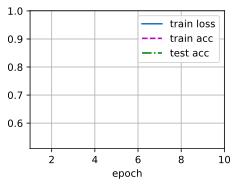

In [11]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())